Setup + imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)  # reproducible


Define the 5×6 binary patterns (A, B, C) and a small helper

In [2]:
# Define 6 rows × 5 cols patterns (rows = 6, cols = 5)
A_6x5 = np.array([
    [0,1,1,1,0],
    [1,0,0,0,1],
    [1,0,0,0,1],
    [1,1,1,1,1],
    [1,0,0,0,1],
    [1,0,0,0,1],
], dtype=float)

B_6x5 = np.array([
    [1,1,1,1,0],
    [1,0,0,0,1],
    [1,1,1,1,0],
    [1,0,0,0,1],
    [1,0,0,0,1],
    [1,1,1,1,0],
], dtype=float)

C_6x5 = np.array([
    [0,1,1,1,1],
    [1,0,0,0,0],
    [1,0,0,0,0],
    [1,0,0,0,0],
    [1,0,0,0,0],
    [0,1,1,1,1],
], dtype=float)

def flatten(img):
    return img.flatten()  # 6x5 -> 30


Build a dataset with noisy variants


In [3]:
def make_dataset(n_per_class=200, noise_prob=0.05, seed=0):
    rng = np.random.default_rng(seed)
    patterns = [flatten(A_6x5), flatten(B_6x5), flatten(C_6x5)]
    X_list, Y_list = [], []
    for cls_idx, base in enumerate(patterns):
        for _ in range(n_per_class):
            x = base.copy()
            flips = rng.random(x.shape) < noise_prob
            x[flips] = 1.0 - x[flips]
            X_list.append(x)
            y = np.zeros(3); y[cls_idx] = 1.0
            Y_list.append(y)
    X = np.stack(X_list)
    Y = np.stack(Y_list)
    # shuffle
    perm = rng.permutation(len(X))
    return X[perm], Y[perm]

# create dataset and split train/val
X, Y = make_dataset(n_per_class=300, noise_prob=0.05, seed=0)
split = int(0.8 * X.shape[0])
X_train, Y_train = X[:split], Y[:split]
X_val,   Y_val   = X[split:], Y[split:]
print("Shapes:", X_train.shape, Y_train.shape, X_val.shape)


Shapes: (720, 30) (720, 3) (180, 30)


Network architecture & weight initialization

In [4]:
input_dim = 30
hidden_dim = 16  # tunable
output_dim = 3

rng = np.random.default_rng(2)
W1 = 0.1 * rng.standard_normal((input_dim, hidden_dim))
b1 = np.zeros((1, hidden_dim))
W2 = 0.1 * rng.standard_normal((hidden_dim, output_dim))
b2 = np.zeros((1, output_dim))


Activation, forward pass

In [5]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def forward(X):
    z1 = X @ W1 + b1        # (N, H)
    a1 = sigmoid(z1)        # (N, H)
    z2 = a1 @ W2 + b2       # (N, 3)
    a2 = sigmoid(z2)        # (N, 3)
    return {"z1": z1, "a1": a1, "z2": z2, "a2": a2}


Loss (Binary Cross-Entropy) and accuracy metric

In [6]:
def bce_loss(y_true, y_pred, eps=1e-9):
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))


Backpropagation: math & code

In [7]:
def backprop_update(Xb, Yb, lr=0.5):
    global W1, b1, W2, b2
    N = Xb.shape[0]
    cache = forward(Xb)
    a1, a2 = cache["a1"], cache["a2"]

    # gradient at output (batch averaged)
    dz2 = (a2 - Yb) / N              # (N,3)
    dW2 = a1.T @ dz2                 # (H,3)
    db2 = np.sum(dz2, axis=0, keepdims=True)

    # hidden gradients
    da1 = dz2 @ W2.T                 # (N,H)
    dz1 = da1 * a1 * (1 - a1)        # (N,H)
    dW1 = Xb.T @ dz1                 # (30,H)
    db1 = np.sum(dz1, axis=0, keepdims=True)

    # update params (gradient descent)
    W2 -= lr * dW2
    b2 -= lr * db2
    W1 -= lr * dW1
    b1 -= lr * db1

    # return current loss & acc
    loss = bce_loss(Yb, a2)
    acc  = accuracy(Yb, a2)
    return loss, acc


Training loop (full batching) + validation monitoring

In [8]:
epochs = 1500
lr = 0.5

hist = {"loss_tr": [], "acc_tr": [], "loss_val": [], "acc_val": []}

for ep in range(1, epochs + 1):
    loss_tr, acc_tr = backprop_update(X_train, Y_train, lr=lr)
    val_pred = forward(X_val)["a2"]
    loss_val = bce_loss(Y_val, val_pred)
    acc_val  = accuracy(Y_val, val_pred)

    hist["loss_tr"].append(loss_tr)
    hist["acc_tr"].append(acc_tr)
    hist["loss_val"].append(loss_val)
    hist["acc_val"].append(acc_val)

    if ep % 100 == 0:
        print(f"Epoch {ep:4d}: train loss {loss_tr:.4f}, train acc {acc_tr:.3f} | val loss {loss_val:.4f}, val acc {acc_val:.3f}")


Epoch  100: train loss 0.0313, train acc 1.000 | val loss 0.0301, val acc 1.000
Epoch  200: train loss 0.0118, train acc 1.000 | val loss 0.0111, val acc 1.000
Epoch  300: train loss 0.0071, train acc 1.000 | val loss 0.0066, val acc 1.000
Epoch  400: train loss 0.0051, train acc 1.000 | val loss 0.0046, val acc 1.000
Epoch  500: train loss 0.0039, train acc 1.000 | val loss 0.0035, val acc 1.000
Epoch  600: train loss 0.0032, train acc 1.000 | val loss 0.0029, val acc 1.000
Epoch  700: train loss 0.0027, train acc 1.000 | val loss 0.0024, val acc 1.000
Epoch  800: train loss 0.0023, train acc 1.000 | val loss 0.0021, val acc 1.000
Epoch  900: train loss 0.0020, train acc 1.000 | val loss 0.0018, val acc 1.000
Epoch 1000: train loss 0.0018, train acc 1.000 | val loss 0.0016, val acc 1.000
Epoch 1100: train loss 0.0016, train acc 1.000 | val loss 0.0014, val acc 1.000
Epoch 1200: train loss 0.0015, train acc 1.000 | val loss 0.0013, val acc 1.000
Epoch 1300: train loss 0.0014, train acc

Plot loss & accuracy

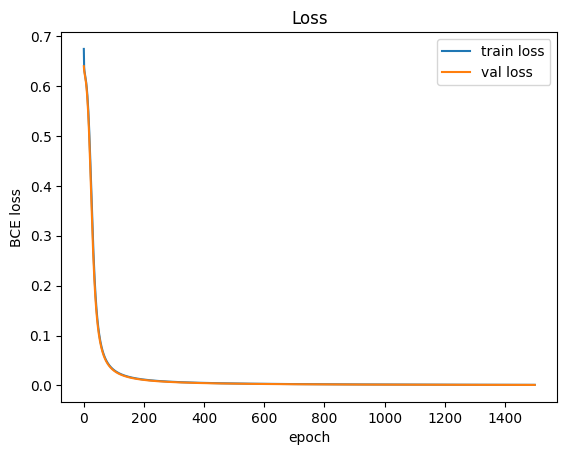

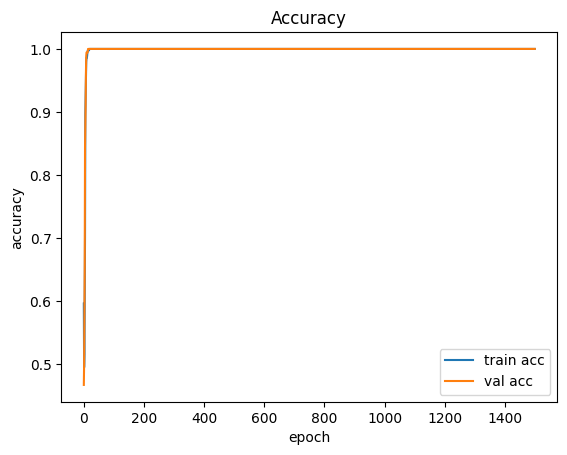

In [9]:
plt.figure()
plt.plot(hist["loss_tr"], label="train loss")
plt.plot(hist["loss_val"], label="val loss")
plt.xlabel("epoch"); plt.ylabel("BCE loss"); plt.legend(); plt.title("Loss")
plt.show()

plt.figure()
plt.plot(hist["acc_tr"], label="train acc")
plt.plot(hist["acc_val"], label="val acc")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.title("Accuracy")
plt.show()


Test on clean samples and show images

Clean A -> predicted class 0 (0=A,1=B,2=C), probs=[[0.999 0.001 0.001]]
Clean B -> predicted class 1 (0=A,1=B,2=C), probs=[[0.001 0.999 0.001]]
Clean C -> predicted class 2 (0=A,1=B,2=C), probs=[[0.    0.    0.999]]


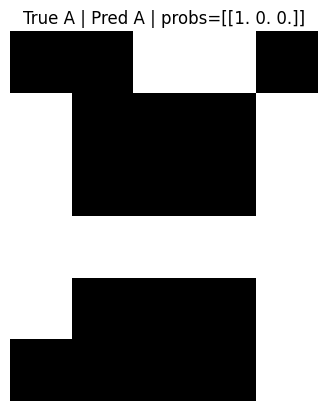

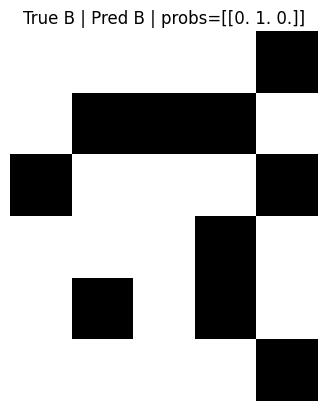

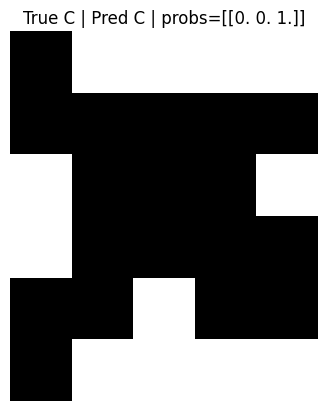

In [10]:
def predict(Xb):
    probs = forward(Xb)["a2"]
    return np.argmax(probs, axis=1), probs

# test on clean exemplars
clean_A = flatten(A_6x5)[None, :]
clean_B = flatten(B_6x5)[None, :]
clean_C = flatten(C_6x5)[None, :]

for name, sample in [("A", clean_A), ("B", clean_B), ("C", clean_C)]:
    cl, probs = predict(sample)
    print(f"Clean {name} -> predicted class {cl[0]} (0=A,1=B,2=C), probs={probs.round(3)}")

# show a few noisy samples and predictions
rng = np.random.default_rng(123)
labels = ["A","B","C"]
for cls in range(3):
    base = flatten([A_6x5, B_6x5, C_6x5][cls])
    x = base.copy()
    flips = rng.random(x.shape) < 0.10  # 10% noise
    x[flips] = 1 - x[flips]
    cl, probs = predict(x[None,:])
    img = x.reshape(6,5)
    plt.figure()
    plt.imshow(img, cmap="gray")
    plt.title(f"True {labels[cls]} | Pred {labels[cl[0]]} | probs={probs.round(2)}")
    plt.axis("off")
    plt.show()
